In [3]:
import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from glob import glob
import cv2
import random

In [4]:
import tensorflow as tf

# Check device
device_name = tf.test.gpu_device_name()
if device_name:
    print(f"✅ GPU detected: {device_name}")
else:
    print("❌ GPU not detected. Falling back to CPU. Consider enabling GPU in runtime settings.")


✅ GPU detected: /device:GPU:0


I0000 00:00:1753514239.329441      36 gpu_device.cc:2022] Created device /device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1753514239.329671      36 gpu_device.cc:2022] Created device /device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [5]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ashishmotwani/tomato")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/tomato


In [6]:
data_dir = "/kaggle/input/tomato/train"  # update with your actual path
image_size = (224, 224)

classes = sorted(os.listdir(data_dir))
print("Classes:", classes)

# Image size and batch size
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
train_dir = os.path.join(data_dir, "/kaggle/input/tomato/train")
val_dir = os.path.join(data_dir, "/kaggle/input/tomato/valid")
# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True
)

# Only rescaling for validation
val_datagen = ImageDataGenerator(rescale=1./255)

# Load train data
train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

# Load validation data
val_generator = val_datagen.flow_from_directory(
    directory=val_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Show class names
classes = list(train_generator.class_indices.keys())
print("Classes:", classes)



Classes: ['Bacterial_spot', 'Early_blight', 'Late_blight', 'Leaf_Mold', 'Septoria_leaf_spot', 'Spider_mites Two-spotted_spider_mite', 'Target_Spot', 'Tomato_Yellow_Leaf_Curl_Virus', 'Tomato_mosaic_virus', 'healthy', 'powdery_mildew']
Found 25851 images belonging to 11 classes.
Found 6683 images belonging to 11 classes.
Classes: ['Bacterial_spot', 'Early_blight', 'Late_blight', 'Leaf_Mold', 'Septoria_leaf_spot', 'Spider_mites Two-spotted_spider_mite', 'Target_Spot', 'Tomato_Yellow_Leaf_Curl_Virus', 'Tomato_mosaic_virus', 'healthy', 'powdery_mildew']


In [7]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    "/kaggle/input/tomato/train",
    image_size=(224, 224),
    batch_size=32,
    label_mode='categorical',
    validation_split=0.2,
    subset='training',
    seed=42,
    crop_to_aspect_ratio=True  # Prevent distortion
)


val_ds = tf.keras.utils.image_dataset_from_directory(
    "/kaggle/input/tomato/valid",
    image_size=(224, 224),
    batch_size=32,
    label_mode='categorical'
)

# Preprocessing and performance
AUTOTUNE = tf.data.AUTOTUNE

def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_ds = train_ds.map(preprocess, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

val_ds = val_ds.map(preprocess, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25851 files belonging to 11 classes.
Using 20681 files for training.


I0000 00:00:1753514259.081290      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1753514259.081537      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 6683 files belonging to 11 classes.


In [8]:
image_paths = []
labels = []

for class_name in classes:
    class_folder = os.path.join(data_dir, class_name)
    for img_file in os.listdir(class_folder):
        image_paths.append(os.path.join(class_folder, img_file))
        labels.append(class_name)

label_df = pd.DataFrame({"image": image_paths, "label": labels})
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(labels), y=labels)
weights_dict = {i: w for i, w in enumerate(class_weights)}

print("Class Weights:", weights_dict)

Class Weights: {0: 0.8315962169465354, 1: 0.9572671727457878, 2: 0.7549280144847123, 3: 0.853337294513765, 4: 0.8154375118289067, 5: 1.3452151740646303, 6: 1.2863113897596656, 7: 1.152570333050961, 8: 1.0915424566144492, 9: 0.7702690623044606, 10: 2.340727997102499}


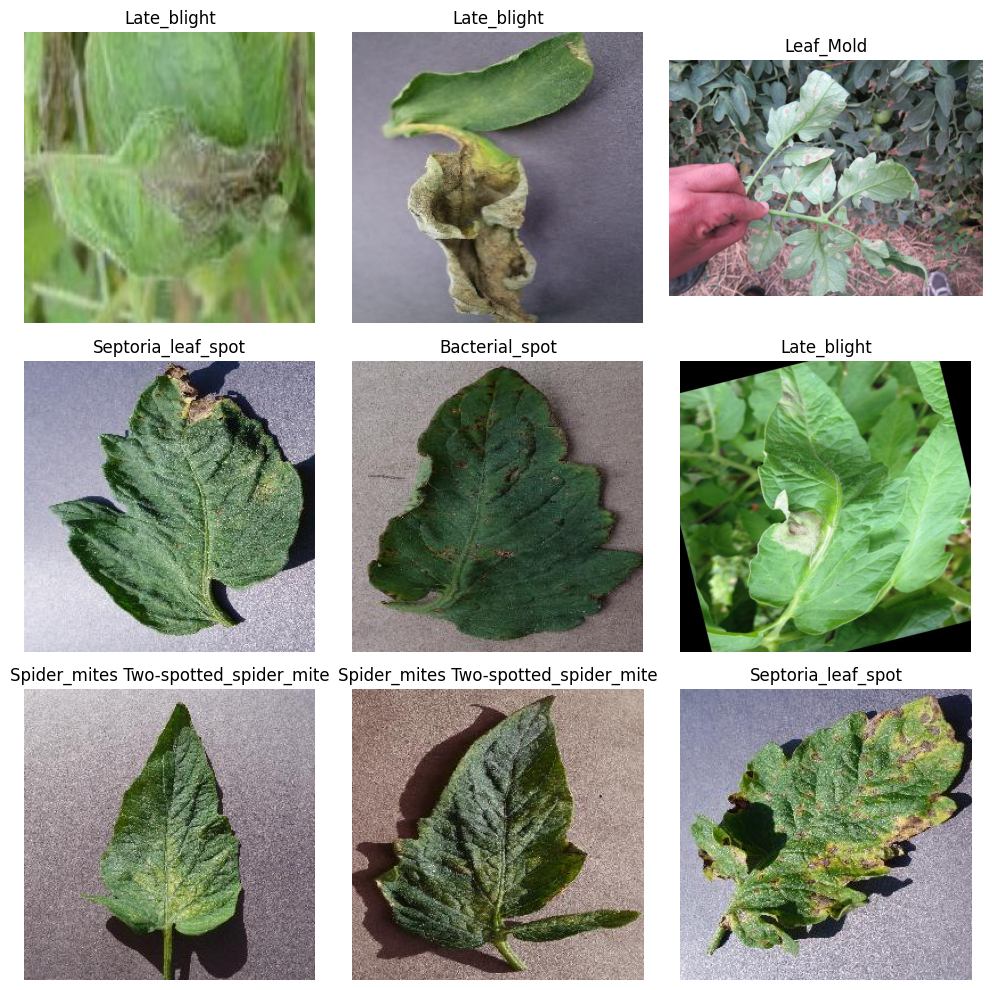

In [9]:
plt.figure(figsize=(10, 10))
for i in range(9):
    path = random.choice(image_paths)
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(path.split(os.path.sep)[-2])
    plt.axis("off")
plt.tight_layout()
plt.show()

In [10]:
train_df, test_df = train_test_split(label_df, test_size=0.2, stratify=label_df['label'], random_state=42)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

valid_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_dataframe(train_df, x_col='image', y_col='label',
                                              target_size=image_size, class_mode='categorical')
test_gen = valid_datagen.flow_from_dataframe(test_df, x_col='image', y_col='label',
                                             target_size=image_size, class_mode='categorical', shuffle=False)

Found 20680 validated image filenames belonging to 11 classes.
Found 5171 validated image filenames belonging to 11 classes.


In [11]:
print("Train classes:", train_gen.class_indices)
print("Test classes:", test_gen.class_indices)


Train classes: {'Bacterial_spot': 0, 'Early_blight': 1, 'Late_blight': 2, 'Leaf_Mold': 3, 'Septoria_leaf_spot': 4, 'Spider_mites Two-spotted_spider_mite': 5, 'Target_Spot': 6, 'Tomato_Yellow_Leaf_Curl_Virus': 7, 'Tomato_mosaic_virus': 8, 'healthy': 9, 'powdery_mildew': 10}
Test classes: {'Bacterial_spot': 0, 'Early_blight': 1, 'Late_blight': 2, 'Leaf_Mold': 3, 'Septoria_leaf_spot': 4, 'Spider_mites Two-spotted_spider_mite': 5, 'Target_Spot': 6, 'Tomato_Yellow_Leaf_Curl_Virus': 7, 'Tomato_mosaic_virus': 8, 'healthy': 9, 'powdery_mildew': 10}


In [12]:
x_batch, y_batch = next(train_gen)
print("Sample image shape:", x_batch[0].shape)
print("Sample label (one-hot):", y_batch[0])


Sample image shape: (224, 224, 3)
Sample label (one-hot): [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [13]:
print("Total training samples:", train_gen.samples)
print("Total testing samples:", test_gen.samples)


Total training samples: 20680
Total testing samples: 5171


In [15]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

def build_fast_edgeleaf_tunenet_tl(input_shape=(224, 224, 3), num_classes=10, dropout_rate=0.3, l2_strength=1e-4, fine_tune_at=100):
    base_model = MobileNetV3Small(weights="imagenet", include_top=False, input_tensor=Input(shape=input_shape))
    
    # Enable fine-tuning after layer `fine_tune_at`
    base_model.trainable = True
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False

    # Freeze all BatchNorm layers for stable training
    for layer in base_model.layers:
        if isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(128, activation='relu', kernel_regularizer=l2(l2_strength))(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(num_classes, activation='softmax', kernel_regularizer=l2(l2_strength))(x)

    model = Model(inputs=base_model.input, outputs=outputs, name="EdgeLeaf-TuneNet-TL")
    return model

# Build model
model = build_fast_edgeleaf_tunenet_tl(input_shape=(224, 224, 3), num_classes=len(classes))

# Compile model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Define fast-training callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, min_lr=1e-6)
]

In [16]:
model.summary()

Model: "EdgeLeaf-TuneNet-TL"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 112, 112,  │        432 │ rescaling_1[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 112, 112,  │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_18       │ (None, 112, 112,  │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 113, 113,  │          0 │ activation_18[0]… │
│ (ZeroPadding2D)     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 56, 56,    │        144 │ expanded_conv_de… │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 56, 56,    │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_14 (ReLU)     │ (None, 56, 56,    │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │          0 │ re_lu_14[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │        136 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │          0 │ expanded_conv_sq… │
│ (ReLU)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │        144 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_9 (Add)         │ (None, 1, 1, 16)  │          0 │ expanded_conv_sq… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_15 (ReLU)     │ (None, 1, 1, 16)  │          0 │ add_9[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_9          │ (None, 1, 1, 16)  │          0 │ re_lu_15[0][0]    │
│ (Multiply)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 56, 56,    │          0 │ re_lu_14[0][0],   │
│ (Multiply)          │ 16)               │            │ multiply_9[0][0]  │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,017,211 (3.88 MB)

 Trainable params: 824,299 (3.14 MB)

 Non-trainable params: 192,912 (753.56 KB)

In [17]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

callbacks = [lr_scheduler]


In [18]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3)

In [19]:
import tensorflow as tf

strategy = tf.distribute.MirroredStrategy()
print("Number of devices:", strategy.num_replicas_in_sync)


Number of devices: 2


In [20]:
with strategy.scope():
    model = build_fast_edgeleaf_tunenet_tl(input_shape=(224, 224, 3), num_classes=len(classes))
    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )



In [21]:
import os
from PIL import Image

def clean_dataset(folder_path):
    removed = []
    for root, _, files in os.walk(folder_path):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                with Image.open(file_path) as img:
                    img.verify()  # Will raise exception if not a real image
            except Exception:
                print(f"❌ Removed: {file_path}")
                os.remove(file_path)
                removed.append(file_path)
    print(f"\n✅ Cleaning done. Total removed: {len(removed)}")
    return removed

# Clean both train and validation directories
clean_dataset("/kaggle/input/tomato/train")
clean_dataset("/kaggle/input/tomato/valid")



✅ Cleaning done. Total removed: 0

✅ Cleaning done. Total removed: 0


[]

In [22]:
train_generator = train_datagen.flow_from_directory(
    directory="/kaggle/input/tomato/train",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    directory="/kaggle/input/tomato/valid",
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 25851 images belonging to 11 classes.
Found 6683 images belonging to 11 classes.


In [23]:
# Now train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,
    callbacks=callbacks
)


InvalidArgumentError: {{function_node __wrapped__IteratorGetNextAsOptional_device_/job:localhost/replica:0/task:0/device:GPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]
	 [[MultiDeviceIteratorGetNextFromShard]]
	 [[RemoteCall]] [Op:IteratorGetNextAsOptional] name: 

In [ ]:
# Predictions
y_true = test_gen.classes
y_pred = model.predict(test_gen)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification Report
print(classification_report(y_true, y_pred_classes, target_names=classes))


In [ ]:
# Confusion Matrix
plt.figure(figsize=(6, 6))
cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Learning Curves
plt.figure(figsize=(18, 12)

In [ ]:
# Accuracy
plt.subplot(3, 3, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

# Loss
plt.subplot(3, 3, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()

# Precision, Recall, F1 (Manual)
from sklearn.metrics import precision_score, recall_score, f1_score

plt.subplot(3, 3, 3)
f1 = f1_score(y_true, y_pred_classes, average='macro')
precision = precision_score(y_true, y_pred_classes, average='macro')
recall = recall_score(y_true, y_pred_classes, average='macro')
plt.bar(['F1', 'Precision', 'Recall'], [f1, precision, recall])
plt.title("F1, Precision, Recall")

plt.tight_layout()
plt.show()

In [ ]:
# Random features for visualization
metrics_df = pd.DataFrame({
    "Accuracy": history.history['val_accuracy'],
    "Loss": history.history['val_loss'],
    "Epoch": np.arange(1, len(history.history['val_accuracy'])+1)
})

sns.pairplot(metrics_df, kind='scatter')
plt.suptitle("Scatter Pair Plot", y=1.02)
plt.show()

sns.pairplot(metrics_df, kind='reg')
plt.suptitle("Line Pair Plot", y=1.02)
plt.show()

sns.pairplot(metrics_df, kind='kde')
plt.suptitle("Distribution Pair Plot", y=1.02)
plt.show()